# Increasing noise BDAE (Convolutional)


## Data loading and processing

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
!pip install -q tensorflow
%load_ext tensorboard

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
trainval_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=False,
                                  download=True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:05<00:00, 1857243.77it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 377694.51it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3135743.36it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10684536.61it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



In [4]:
train_data, val_data = random_split(trainval_data, [50_000, 10_000])

# how many samples per batch to load
batch_size = 64

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

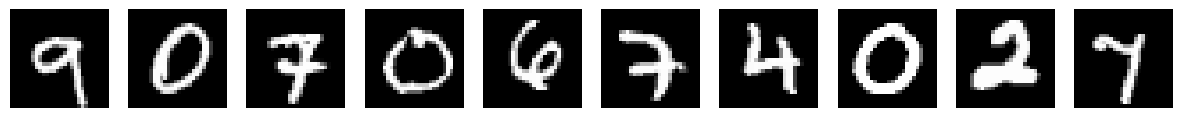

In [5]:
# Get a batch of training data
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Plot the first 10 images
fig, axes = plt.subplots(1, 10, figsize=(15, 1.5))
for i in range(10):
    ax = axes[i]
    ax.imshow(images[i].numpy().squeeze(), cmap='gray')
    ax.axis('off')

plt.show()

## Autoencoder Architectures

In [6]:
dropout_rate = 0.2

def MC_dropout(act_vec, p=0.5, mask=True):
  return F.dropout(act_vec, p=p, training=mask, inplace=False)

class ConvolutionalBDAE(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder layers
        self.conv1 = nn.Conv2d(1, 64, 3, stride=2, padding=1)  # Increased number of output channels
        self.conv2 = nn.Conv2d(64, 128, 3, stride=2, padding=1)  # Increased number of output channels
        self.conv3 = nn.Conv2d(128, 256, 7)  # Increased number of output channels

        # Decoder layers
        self.deconv1 = nn.ConvTranspose2d(256, 128, 7)  # Increased number of input channels
        self.deconv2 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)  # Increased number of input channels
        self.deconv3 = nn.ConvTranspose2d(64, 1, 3, stride=2, padding=1, output_padding=1)  # Increased number of input channels
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, dropout_p=dropout_rate, apply_dropout=True):
        # Encoder
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # Decoder
        x = F.relu(self.deconv1(x))
        x = MC_dropout(x, p=dropout_p, mask=apply_dropout)
        x = F.relu(self.deconv2(x))
        x = MC_dropout(x, p=dropout_p, mask=apply_dropout)
        x = self.sigmoid(self.deconv3(x))

        return x

    def sample_predict(self, x, Nsamples):
      predictions = x.data.new(Nsamples, x.shape[0], 28*28)
      for i in range(Nsamples):
        y = self.forward(x)
        predictions[i] = y.view(-1, 28*28)

      predictions_mean = torch.mean(predictions, dim=0)
      predictions_var = torch.var(predictions, dim=0)

      predictions_mean = predictions_mean.view(-1, 1, 28, 28)
      predictions_var = predictions_var.view(-1, 1, 28, 28)

      return predictions, predictions_mean, predictions_var

## Noise schemes

In [7]:
def add_gaussian_noise(images, noise_factor=0.5):
  corrupted_images = images + noise_factor * torch.randn(*images.shape)
  corrupted_images = np.clip(corrupted_images, 0., 1.)
  return corrupted_images

## Training Process

### Training functions

In [8]:
def train(train_loader, net, optimizer, criterion, noise_factor):
  total_loss = 0

  for i, data in enumerate(train_loader):

        images, _ = data
        # images = images.view(images.size(0), -1)

        # ADD NOISE PROCESS
        corrupted_images = add_gaussian_noise(images, noise_factor)

        images = images.to(device)
        corrupted_images = corrupted_images.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net.forward(corrupted_images)

        loss = criterion(outputs, images)

        loss.backward()
        optimizer.step()

        # keep track of loss and accuracy
        total_loss += loss.item() * images.size(0)

  avg_loss = total_loss/len(train_loader.dataset)  # Compute average loss

  return avg_loss

In [9]:
def validation(val_loader, net, criterion, Nsamples, noise_factor):
  total_loss = 0

  # Use torch.no_grad to skip gradient calculation, not needed for evaluation
  with torch.no_grad():
      # iterate through batches
        for data in val_loader:
            # get the inputs; data is a list of [inputs, labels]
            images, _ = data
            # images = images.view(images.size(0), -1)

            corrupted_images = add_gaussian_noise(images, noise_factor)

            images = images.to(device)
            corrupted_images = corrupted_images.to(device)

            # forward pass
            predictions, predictions_mean, predictions_var = net.sample_predict(corrupted_images, Nsamples)
            # print('predictions_mean:', predictions_mean.shape)
            # outputs = net.forward(corrupted_images)
            loss = criterion(predictions_mean, images) #changed from predictions_mean to outputs

            # keep track of loss and accuracy
            total_loss += loss.item() * images.size(0)

  return total_loss/len(val_loader.dataset)

### Training Procedure

##### Noise factor = 0.3

In [11]:
torch.manual_seed(42)

convolutional_model_03 = ConvolutionalBDAE().to(device)
criterion = nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(convolutional_model_03.parameters(), lr=learning_rate)

noise_factor = 0.3

num_epochs = 10

Nsamples = 15

for epoch in tqdm(range(num_epochs)):  # loop over the dataset multiple times
    # Train on data
    train_loss = train(train_loader, convolutional_model_03, optimizer, criterion, noise_factor)

print('Finished Training')

100%|██████████| 10/10 [02:27<00:00, 14.79s/it]

Finished Training


## Visualizations Linear

### Clean images

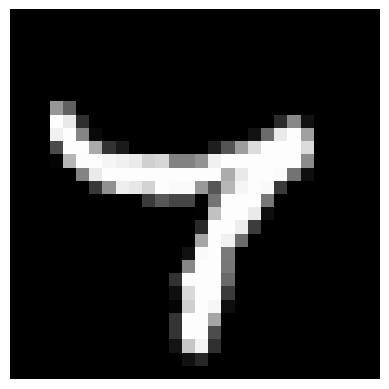

In [17]:
# Specify the index of the image you want to retrieve
i = 124  # Change this index to get a different image

# Retrieve the i-th image and its label
image, _ = test_data[i]

plt.imshow(image.squeeze(), cmap='gray')
plt.axis('off')
plt.show()

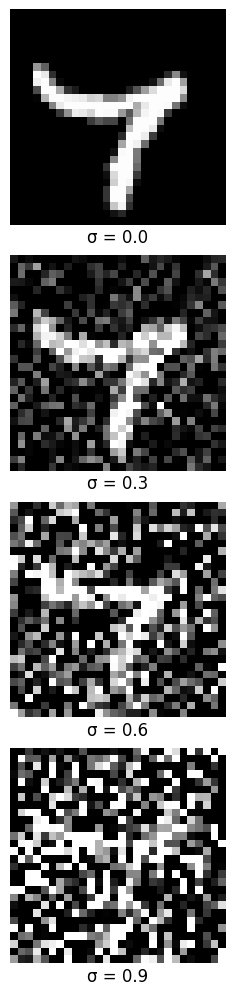

In [18]:
# Define the noise levels
noise_levels = [0.0, 0.3, 0.6, 0.9]
# noise_levels = [0.0, 0.2, 0.4, 0.6]

# Create a plot of 4 rows by 1 column
fig, axs = plt.subplots(4, 1, figsize=(5, 10))

noisy_images = []

# Plot the images with different levels of Gaussian noise
for idx, noise_level in enumerate(noise_levels):
    noisy_image = add_gaussian_noise(image, noise_factor=noise_level)
    # noisy_image = add_salt_pepper_noise(image, 0.1)
    noisy_images.append(noisy_image)

    axs[idx].imshow(noisy_image.squeeze(), cmap='gray')
    axs[idx].set_title(f"σ = {noise_level}", y=-0.12)
    axs[idx].axis('off')

# Show the plot
plt.tight_layout()
plt.show()

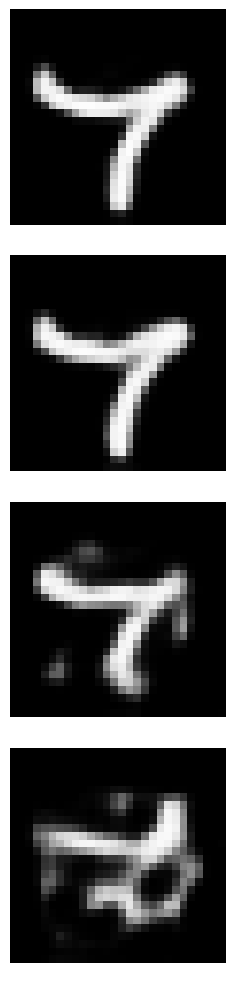

In [19]:
# Define the noise levels and corresponding models
models = [linear_model_03] * 4  # Replace with your actual models
# models = [linear_model_00, linear_model_02, linear_model_04, linear_model_06]

# Apply noise and denoise images
denoised_means = []
denoised_vars = []


for corrupted_image, model in zip(noisy_images, models):
    model.eval()
    predictions, predictions_mean, predictions_var = model.sample_predict(corrupted_image.to(device), Nsamples)  # Assuming model takes a batch of images
    denoised_means.append(predictions_mean.view(28,28).cpu().detach().numpy())
    denoised_vars.append(predictions_var.view(28,28).cpu().detach().numpy())

# Create a plot of 4 rows by 1 column for denoised images
fig, axs = plt.subplots(4, 1, figsize=(5, 10))

# Plot the denoised images
for idx, denoised_image in enumerate(denoised_means):
    axs[idx].imshow(denoised_image, cmap='gray', vmax=1)
    axs[idx].set_title(f"   ", y=-0.12)
    axs[idx].axis('off')

# Show the plot
plt.tight_layout()
plt.show()

0.05116383
0.032145083
0.037488576
0.022674423


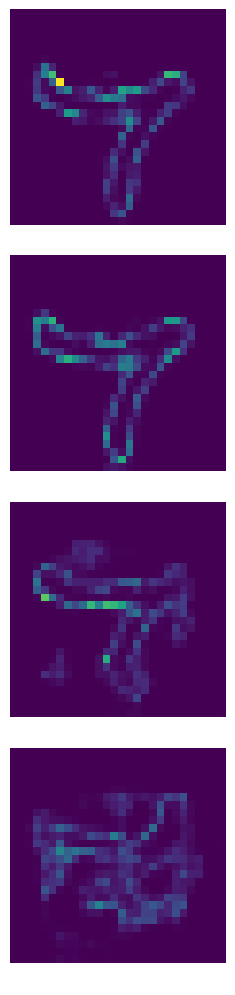

In [21]:
# Create a plot of 4 rows by 1 column for denoised images
fig, axs = plt.subplots(4, 1, figsize=(5, 10))

# Plot the denoised images
for idx, denoised_image in enumerate(denoised_vars):

    print(np.max(denoised_image))

    mean_variance = np.mean(denoised_image)

    axs[idx].imshow(denoised_image, cmap='viridis', vmax=0.05)
    # axs[idx].text(0.95, 0.05, f'{mean_variance:.4f}', size=10, ha='right', va='bottom', color='white', transform=axs[idx].transAxes)
    axs[idx].set_title(f"   ", y=-0.12)
    axs[idx].axis('off')

# Show the plot
plt.tight_layout()
plt.show()

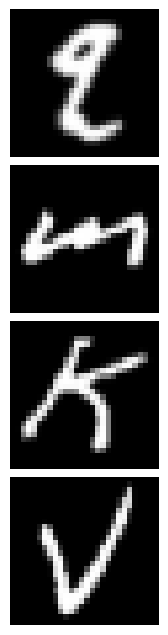

In [33]:
# Download and load the EMNIST dataset
emnist_dataset = datasets.EMNIST(
                root='./data',
                download=True,
                split='letters',
                train=True,
                transform=transforms.Compose([
                    lambda img: transforms.functional.rotate(img, -90),
                    lambda img: transforms.functional.hflip(img),
                    transforms.ToTensor()
                ])
            )

num_images = 4

# Function to plot the images
def plot_images(images, space=0.05, cmap='gray', vmax=None):
    plt.figure(figsize=(2, 8))
    for i in range(num_images):
        plt.subplot(4, 1, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap=cmap, vmax=vmax)
        plt.axis('off')
    plt.subplots_adjust(wspace=space, hspace=space)
    plt.show()


# Initialize images
# Get a different set of 8 images and their labels from the test dataset
start_index = 5  # Change this to select a different starting point
images, labels = zip(*[(emnist_dataset[i][0], emnist_dataset[i][1]) for i in range(start_index, start_index + 64)])

# Plot the images
plot_images(images, 0.05)

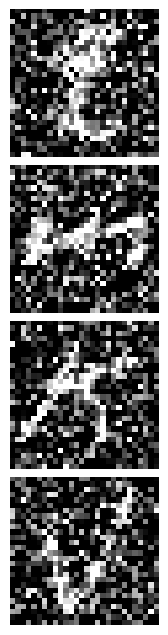

In [37]:
torch_images = torch.stack(images)

noisy_images = add_gaussian_noise(torch_images, 0.5)
plot_images(noisy_images, 0.05, vmax=1)

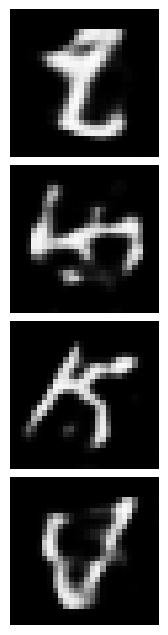

In [39]:
# noisy_images_flattened = noisy_images.view(noisy_images.size(0), -1).to(device)
linear_model_03.eval()
with torch.no_grad():
    _, predictions_mean, predictions_var = linear_model_03.sample_predict(noisy_images.to(device), Nsamples)

plot_images(predictions_mean.view(-1,28,28).cpu(), 0.05, vmax=1)

0.04154846


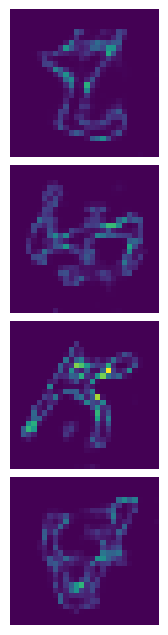

In [40]:
max_pixel = np.max(predictions_var.cpu().numpy()[:4])
print(max_pixel)

plot_images(predictions_var.view(-1,28,28).cpu(), 0.05, 'viridis', max_pixel)